# Dollar Cost Averaging - Custom DCA (buy the dip)


### Overview
Dollar Cost Averaging: Dividing a sum of investment money to be invested periodically to reduce the impact of volatility on the purchase price. If you want a risk mitigating way to invest in crypto DCA is the standard procedure. But can we do better?

**Buy the dip** - I'm sure you've heard it before but it's easier said than done. The indicators in this repo are provided to help buy the dip algorithmically: or scale the amount per DCA order to invest more when it's likely crpyto is dipping and less when it is not.

This repo lets you run and backtest DCA strategies for crypto to minimise risk and maximise profits allowing for user customisation with respect to frequency of buy strategy, use of indicators and aggression of parammeter scaling

### Setup instructions

1. To get started you will need an exchange account from Binance/FTX/Kraken (Fee reducing referral links below):

    - [x] [binance.com](https://accounts.binance.com/en/register?ref=CP1DAOWU)
    - [x] [ftx.com](https://ftx.com/#a=33799830)
    - [ ] [kraken.com](https://r.kraken.com/KeJqje)


2. Load up your spot wallet with USD or USDT or whatever currency you want to use to buy crypto 
<br></br><br></br>
3. Create API keys with 'trading' permissions enabled and load 
<br></br><br></br>
4. Put your API keys in a json_file called `keys.json` (Only the exchange keys used to trade need to be included)

```
{
    "binance_keys":{
        "api_key":"XXXXXXXXXXXXXXXXXXXX",
        "secret_key":"XXXXXXXXXXXXXXXXXXXX"
    },
    "ftx_keys":{
        "api_key":"XXXXXXXXXXXXXXXXXXXX",
        "secret_key":"XXXXXXXXXXXXXXXXXXXX"
    },
    "kraken_keys":{
    	"api_key":"XXXXXXXXXXXXXXXXXXXX",
        "secret_key":"XXXXXXXXXXXXXXXXXXXX"
    }
}
```

5. Install the required python packages using `pip install -r requirements.txt` from the root directory
<br></br><br></br>
6. Run `python dca.py` to start or `python dca.py -s` to start in simulation mode (places fake trades)
<br></br><br></br>
7. Follow the instructions in the command prompt to set up alternatively use the config.json file (Work in progress) 

Places (spot) market buy orders on the exchange at the current price, it then sleeps until the next buy interval. It will save progress so it doesn't have to be continuously run but I would reccomend running this perpetually (on a linux based microcomputer like a Rasberry Pi). Different DCA strategies will be put in as we go!

Strategies tested and planning to be tested:
- [x] According to the Crypto Fear and Greed Index https://alternative.me/crypto/fear-and-greed-index (Buys more when fear is higher, buys less when greed is higher)
- [ ] RSI based DCA
- [ ] Volatility Based DCA


## Fear and Greed
![fear_greed](fg_btc.png)

<img src="https://alternative.me/crypto/fear-and-greed-index.png" alt="Latest Crypto Fear & Greed Index" width="300" height="300" />

The fear and greed strategy uses 100 - fear and greed index (red) against bitcoin price (blue). The indicator for a greater weight for DCA when fear is high shown by a number closer to 100 on this chart and a lower weight when greed is high when the number is closer to 0. By doing this we can invest according to this scaling and increase the amount of BTC held over a long period of time


### Updates
August 27th
FTX Set up and more intuitive UI. Also more backtesting in the analysis notbook

August 12th:
Fear and greed DCA handling for buy amounts lower than the minimum buy amount for each coin

August 8th:
Basic DCA works for all cryptos on Binance, needs to be run permanently



## Notebook to test out different DCA strategies

Ways to optimise getting into crypto minimising risk and maximising profit

- Regular Dollar Cost averaging
- Inversely proportional to the crypto fear and greed index
- Exponentially decreasing with price increase
- Proportional to RSI
- Inversely proportional to stock to flow

In [1]:
import json
import traceback
import ccxt
from datetime import datetime, timedelta
import time
import pytz
from datetime import timedelta
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from itertools import accumulate
import matplotlib
import pandas as pd
import numpy as np

In [2]:
# Using binance for now
exchange = ccxt.binance({})

In [3]:
# Get tickers for coins you want to buy
btc = 'BTC/USDT'
eth = 'ETH/USDT'
link = 'LINK/USDT'
sol = 'SOL/USDT'
ada = 'ADA/USDT'
dot = 'DOT/USDT'
luna = 'LUNA/USDT'
uni = 'UNI/USDT'
sushi = 'SUSHI/USDT'
ftt = 'FTT/USDT'

all_tickers = {'btc':{'ticker':btc}, 
               'eth':{'ticker':eth}, 
#               'link':{'ticker':link}, 
#                'sol':{'ticker':sol}, 
#                'ada':{'ticker':ada}, 
#                'dot':{'ticker':dot}, 
#               'luna':{'ticker':luna}, 
#                'uni':{'ticker':uni}, 
#              'sushi':{'ticker':sushi}, 
#                'ftt':{'ticker':ftt}, 
              }

# Get 3 years of historical data
start_date = datetime.now() - timedelta(days=365*4)
start_timestamp = round(start_date.timestamp() * 1000)

In [4]:
# Convert data from binance to pandas df
def convert_pandas(data):
    header = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    df = pd.DataFrame(data, columns=header).set_index('timestamp')
    df.index = df.index.map(lambda x : datetime.fromtimestamp(round(x/1000)))
    return df

# Convert a datetime to the local timezone
def convert_timezone(dt,from_tz=pytz.timezone('UTC'),to_tz=pytz.timezone('Europe/London')):
    utc_dt = dt.replace(tzinfo=from_tz)
    return utc_dt.astimezone(to_tz)

# Get the data from a ticker since it's earliest interval to present
def fetch_data(ticker, since, until=datetime.now(), interval='1d'):
    
    week_data = exchange.fetch_ohlcv(ticker,'1w')
    since = max(since,week_data[0][0])
    data = exchange.fetch_ohlcv(ticker, interval, since=since)
    
    while data and datetime.fromtimestamp(data[-1][0]/1000) < until - timedelta(days=1):
        data += exchange.fetch_ohlcv(ticker, interval, since=data[-1][0])[1:]
        
    return data  

In [5]:
for k,v in all_tickers.items():
    all_tickers[k]['data'] = fetch_data(v['ticker'], start_timestamp)    

In [6]:
for k in all_tickers:
    all_tickers[k]['df'] = convert_pandas(all_tickers[k]['data'])

In [7]:
data_df = pd.DataFrame()
for coin in all_tickers:
    temp_df = all_tickers[coin]['df']
    temp_df['ticker'] = coin
    data_df = data_df.append(temp_df)

In [8]:
data_df

,open,high,low,close,volume,ticker
timestamp,,,,,,
2017-09-13 01:00:00,4159.72,4165.38,3760.00,3944.69,9.134625e+02,btc
2017-09-14 01:00:00,3944.00,3993.00,3165.13,3189.02,1.665022e+03,btc
2017-09-15 01:00:00,3188.01,3856.00,2817.00,3700.00,1.968866e+03,btc
2017-09-16 01:00:00,3674.01,3950.00,3470.66,3714.95,1.297564e+03,btc
2017-09-17 01:00:00,3685.23,3748.21,3499.02,3699.99,6.821712e+02,btc
...,...,...,...,...,...,...
2021-09-07 01:00:00,3926.67,3947.15,3005.00,3434.57,1.203536e+06,eth
2021-09-08 01:00:00,3434.84,3560.00,3215.16,3499.00,7.806118e+05,eth
2021-09-09 01:00:00,3499.01,3567.06,3390.40,3424.93,6.285539e+05,eth


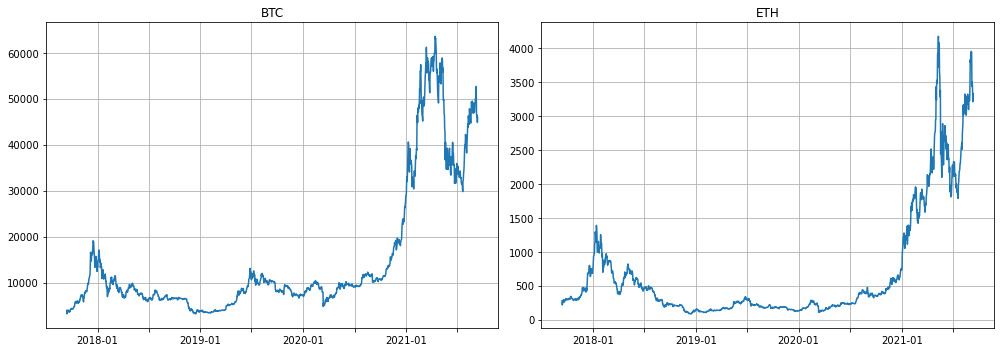

In [9]:
# Plot the individual charts for the coins to dca

fig, ax = plt.subplots(len(all_tickers)//2,2, figsize=(14,5))
for i, ticker in enumerate(all_tickers):
    row, col = i//2, i%2
    ax = ax[row,:] if len(all_tickers) > 2 else ax[:]
    ax[col].plot(data_df[data_df.ticker == ticker].close)
    ax[col].set_title(ticker.upper())
    ax[ col].grid()
    
    every_nth = 2
    for n, label in enumerate(ax[col].xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

fig.tight_layout()
plt.show()

In [10]:
# # Plot the individual charts for the coins to dca

# fig = plt.figure(figsize=(14,5))
# for i, ticker in enumerate(all_tickers):
    
#     plt.plot(data_df[data_df.ticker == ticker].close)
#     plt.title(ticker.upper())
#     plt.grid()

# fig.tight_layout()
# plt.show()

In [11]:
# Scale the df so we can look at the charts together
scaled_df = data_df
scaled_df['avg'] = data_df.groupby('ticker')['close'].transform('mean')
scaled_df['scaled'] = scaled_df.close / scaled_df.avg

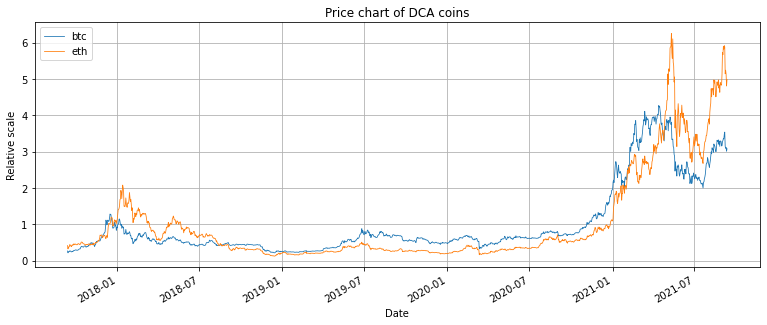

In [12]:
fig = plt.figure(figsize=(13,5))

scaled_df.groupby('ticker')['scaled'].plot(legend=True, linewidth=0.8)

plt.title('Price chart of DCA coins')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Relative scale')
plt.show()

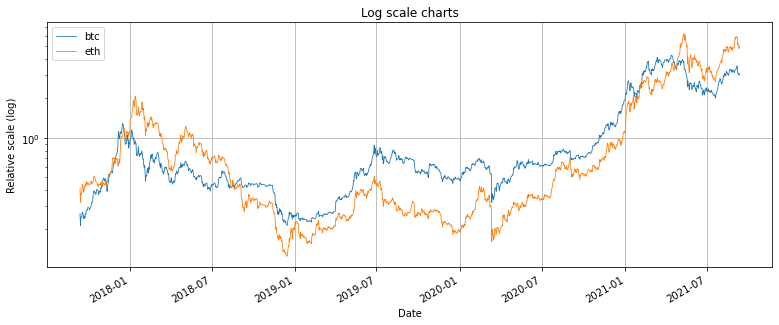

In [13]:
fig = plt.figure(figsize=(13,5))

scaled_df.groupby('ticker')['scaled'].plot(legend=True, logy=True, linewidth=0.8)

plt.title('Log scale charts')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Relative scale (log)')
plt.show()

## The DCA Testing chart

In [14]:
# DCA which gives you the total amount invested over a time period and the average price you would have got
class DCA:
    def __init__(self, total, df, since=datetime.now() - timedelta(days=365*3)):
        self.total = total
        self.since=since
        self.df = df
    
    def weighting(self):
        pass
            
    # Run the dca strategy with the parameters entered
    def get_average(self, dollar_amount, freq, ticker):
        amounts, volumes, spent, break_flag = [], [], 0, False
        
        for i, row in enumerate(self.df[self.df.index > self.since].iterrows()):
            if i % freq == 0:
                volumes.append(dollar_amount / row[1].open)
                amounts.append(1 * row[1].open)
                spent += dollar_amount
                
            if spent >= self.total:
                print('Maximum %.2f invested on: %s' % (spent, row[0].strftime('%b %d %y')))
                break_flag = True
                break
            
        avg_price = sum(amounts) / len(amounts)
        print('DCA Price: $%.6f' % (avg_price))
        print('Spent:     $%.2f' % (spent))
        print('Leftover:  $%.2f' % (self.total - spent))
        print('Made:      $%.2f' % (sum(volumes) * (row[1].open - avg_price)))
        print('Amount:    %.6f %s\n\n' % (sum(volumes), ticker.upper()))
        return volumes
            
    def get_length(self):
        pass


In [15]:
params = {
          'amount':   100000,
          'freq_d':   1,
         }

for ticker in all_tickers:
    
    print(ticker.upper())
    this_df = data_df[data_df.ticker==ticker]
 
    my_dca = DCA(params['amount'], this_df)
    vols = my_dca.get_average(10, params['freq_d'], ticker)

BTC
DCA Price: $17009.983096
Spent:     $10950.00
Leftover:  $89050.00
Made:      $34129.65
Amount:    1.226264 BTC


ETH
DCA Price: $704.341726
Spent:     $10950.00
Leftover:  $89050.00
Made:      $111972.78
Amount:    44.708489 ETH




## Fear and Greed index weighting

In [16]:
import requests 
import ast

In [17]:
# TOEDIT # Returned much quicker due to caching, check and test headers with this

In [18]:
endpoint = 'https://api.alternative.me/fng/?limit=3000&format=json&date_format=uk'
# endpoint = 'https://api.alternative.me/fng'
fg_data =  requests.get(endpoint).json()

In [19]:
endpoint_individual = 'https://api.alternative.me/fng/?format=json&date_format=uk'
fg_data_individual = requests.get(endpoint_individual).json()

In [20]:
fg_data_individual['data'][0]

{'value': '31',
 'value_classification': 'Fear',
 'timestamp': '11-09-2021',
 'time_until_update': '-1631292519'}

In [21]:
fg_values = pd.DataFrame()
fg_values['fear_greed'] = [int(x['value']) for x in fg_data['data']]
fg_values.index = [x['timestamp'] for x in fg_data['data']]
fg_values.index = pd.to_datetime(fg_values.index, dayfirst=True)

In [22]:
scaled_df_date = scaled_df.copy()
scaled_df_date.index = scaled_df_date.index.date
fg_df = scaled_df_date.join(fg_values)
# fg_df = fg_df[(fg_df.index >= fg_df.dropna().index[0])]

fg_df

,open,high,low,close,volume,ticker,avg,scaled,fear_greed
2017-09-13,4159.72,4165.38,3760.00,3944.69,913.462545,btc,14894.748274,0.264838,NaN
2017-09-13,293.93,294.50,257.05,276.91,6451.228360,eth,667.974199,0.414552,NaN
2017-09-14,3944.00,3993.00,3165.13,3189.02,1665.021543,btc,14894.748274,0.214104,NaN
2017-09-14,275.76,283.77,215.00,215.21,12601.956760,eth,667.974199,0.322183,NaN
2017-09-15,3188.01,3856.00,2817.00,3700.00,1968.866492,btc,14894.748274,0.248410,NaN
...,...,...,...,...,...,...,...,...,...
2021-09-09,3499.01,3567.06,3390.40,3424.93,628553.883100,eth,667.974199,5.127339,45.0
2021-09-10,46395.14,47033.00,44132.29,44850.91,49048.266180,btc,14894.748274,3.011190,46.0
2021-09-10,3424.94,3514.11,3150.00,3208.86,633026.265900,eth,667.974199,4.803868,46.0
2021-09-11,44842.20,45987.93,44722.22,45857.19,22688.321080,btc,14894.748274,3.078749,31.0


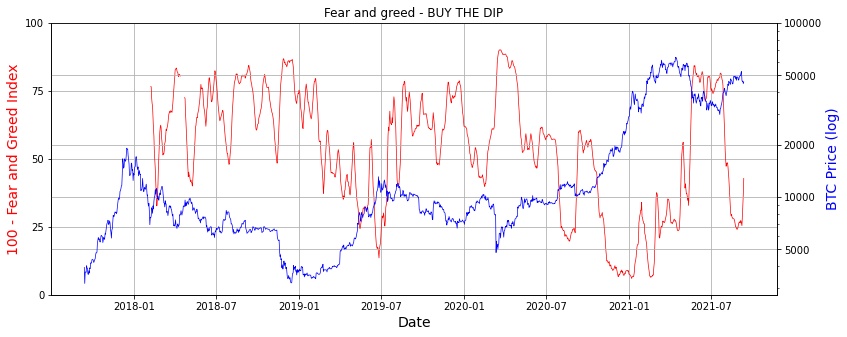

In [23]:
fig,ax = plt.subplots(figsize=(13,5))

ax.plot(fg_df[fg_df.ticker=='btc'].index, 100-fg_df[fg_df.ticker=='btc'].fear_greed.rolling(window=7).mean(), color="red", linewidth=0.7)

ax.set_xlabel("Date",fontsize=14), 
ax.set_yticks([0,25,50,75,100])
ax.set_ylabel("100 - Fear and Greed Index", color="red", fontsize=14)

ax2 = ax.twinx()
ax2.plot(fg_df[fg_df.ticker=='btc'].index, fg_df[fg_df.ticker=='btc'].close, color="blue", linewidth=0.7)
ax2.set_yscale('log')
ax2.set_yticks([5000, 10000, 20000, 50000, 100000])
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylabel("BTC Price (log)", color="blue", fontsize=14)

ax2.grid()
ax.grid()

plt.title('Fear and greed - BUY THE DIP')
# plt.grid()
plt.savefig('fg_btc.png')
plt.show()

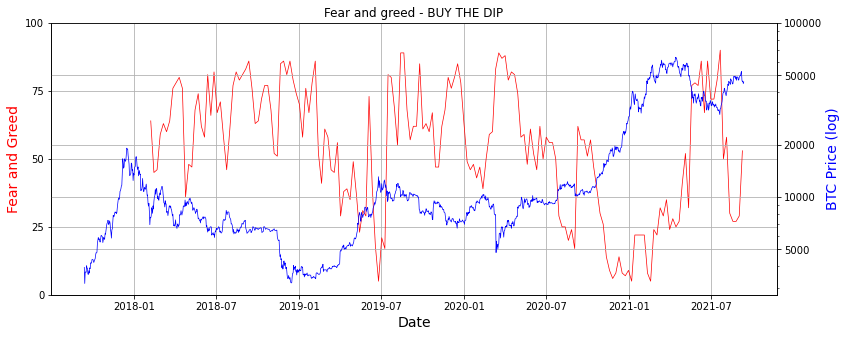

In [24]:
fig,ax = plt.subplots(figsize=(13,5))

ax.plot(fg_df[(fg_df.index.isin(pd.date_range(fg_df.index.min(),fg_df.index.max(),freq='7d')))&(fg_df.ticker=='btc')].index
        , 100-fg_df[(fg_df.index.isin(pd.date_range(fg_df.index.min(),fg_df.index.max(),freq='7d')))&(fg_df.ticker=='btc')].fear_greed
        , color="red", linewidth=0.7)
ax.set_xlabel("Date",fontsize=14)
ax.set_yticks([0,25,50,75,100])
ax.set_ylabel("Fear and Greed", color="red", fontsize=14)

ax2 = ax.twinx()
ax2.plot(fg_df[fg_df.ticker=='btc'].index, fg_df[fg_df.ticker=='btc'].close, color="blue", linewidth=0.7)
ax2.set_yscale('log')
ax2.set_yticks([5000, 10000, 20000, 50000, 100000])
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylabel("BTC Price (log)", color="blue", fontsize=14)

ax2.grid()
ax.grid()

plt.title('Fear and greed - BUY THE DIP')
# plt.grid()
plt.show()

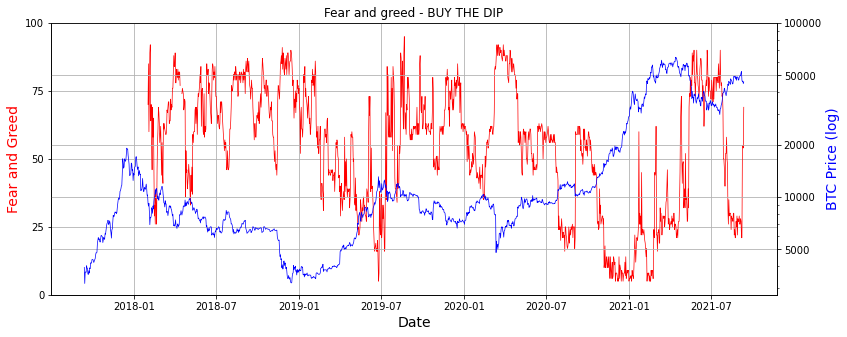

In [25]:
fig,ax = plt.subplots(figsize=(13,5))
ax.plot(fg_df[fg_df.ticker=='btc'].index, 100-fg_df[fg_df.ticker=='btc'].fear_greed, color="red", linewidth=0.7)
ax.set_xlabel("Date",fontsize=14)
ax.set_yticks([0,25,50,75,100])
ax.set_ylabel("Fear and Greed", color="red", fontsize=14)

ax2 = ax.twinx()
ax2.plot(fg_df[fg_df.ticker=='btc'].index, fg_df[fg_df.ticker=='btc'].close, color="blue", linewidth=0.7)
ax2.set_yscale('log')
ax2.set_yticks([5000, 10000, 20000, 50000, 100000])
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.set_ylabel("BTC Price (log)", color="blue", fontsize=14)

ax2.grid()
ax.grid()

plt.title('Fear and greed - BUY THE DIP')
# plt.grid()
plt.show()

In [26]:
ret_row = pd.DataFrame(columns=['price','weight','dollar_spend','dollar_total','dollar_left','crypto','crypto_vol'])

In [27]:
ret_row['price'] = 1
ret_row

,price,weight,dollar_spend,dollar_total,dollar_left,crypto,crypto_vol


In [28]:
# DCA which gives you the total amount invested over a time period and the average price you would have got
class DCA:
    def __init__(self, total, df, since=datetime.now() - timedelta(days=365*3.3)):
        self.total = total
        self.since=since
        self.df = df
    
    # Run the dca strategy with the parameters entered
    def get_average(self, dollar_amount, freq, ticker, weighting=None):
        ret_df, prices, volumes, dates, spent, break_flag = pd.DataFrame(), [], [], [], 0, False
        
        # Loop over every row
        weight = 1
        for i, row in enumerate(self.df[self.df.index > self.since].iterrows()):
            
            if weighting:
                weight = row[1][weighting]
            
            if spent >= self.total:
                ret_df = ret_df.append(pd.DataFrame([[row[0],row[1].open,weight,0,spent,0,0,sum(volumes)]],
                    columns=['date','price','weight','dollar_spend','dollar_spend_tot','dollar_left','crypto_vol','crypto_tot']))
                
            elif i % freq == 0:
                dates.append(row[0])
                
                # Calculate the last amount to if the total amount to spend has run out
                if spent + dollar_amount * weight >= self.total:
                    
                    leftover_dollar = self.total - spent
                    crypto_vol = leftover_dollar / row[1].open
                    volumes.append(crypto_vol)
                    prices.append(row[1].open)
                    spent += leftover_dollar
                    
                    ret_df = ret_df.append(pd.DataFrame([[row[0],row[1].open,weight,leftover_dollar,spent,0,crypto_vol,sum(volumes)]],
                    columns=['date','price','weight','dollar_spend','dollar_spend_tot','dollar_left','crypto_vol','crypto_tot']))
                    continue
                    
                
                crypto_vol = dollar_amount * weight / row[1].open
                dollar_spend = dollar_amount * weight
                
                volumes.append(crypto_vol)
                prices.append(row[1].open)
                spent += dollar_spend
                
                ret_df = ret_df.append(pd.DataFrame([[row[0],row[1].open,weight,dollar_spend,spent,self.total-spent,crypto_vol,sum(volumes)]],
                    columns=['date','price','weight','dollar_spend','dollar_spend_tot','dollar_left','crypto_vol','crypto_tot']))

        return volumes, spent, prices, dates, ret_df.set_index('date')
            
    def get_length(self):
        pass

## Different weighting functions

In [30]:
fg_df.mean().fear_greed

45.784615384615385

In [31]:
fg_w_df = fg_df.copy()

In [32]:
line = np.linspace(0,100,101)
weight_df = pd.DataFrame(line, columns=['line'])
weight_df.sort_values('line', ascending=False).reset_index(inplace=True)
weight_df

,line
0,0.0
1,1.0
2,2.0
3,3.0
4,4.0
...,...
96,96.0
97,97.0
98,98.0
99,99.0


In [33]:
# Applies weighting to a df to plot it out
def apply_weighting(weight_df, weight_dict, xlabel, replace=False, plot=True, cols=4):
    
    fig, ax = plt.subplots(len(weight_dict)//cols+(1 if len(weight_dict)%cols else 0), cols, figsize=(14,len(weight_dict)//2+1))
    
    df = weight_df.copy()
    for i, (weight_name, function) in enumerate(weight_dict.items()):
        
        row, col = i//cols, i%cols
        if len(weight_dict) > 1:
            ax0 = ax[row]
        else:
            ax0 = ax
        
        if weight_name in df.columns and not replace:
            print('Weighting for %s already in df' % weight_name)
            continue

        df[weight_name] = df.line.apply(function)
        
        ax0[col].plot(df[weight_name])
        ax0[col].set_xlabel(xlabel)
        ax0[col].grid()
        ax0[col].set_ylabel('Relative Weight')
        ax0[col].set_title(weight_name)
        ax0[col].set_ylim((-0.1,2.1))
        
    plt.tight_layout()
    plt.show()
    
    return df

In [34]:
weight_dict = {}

In [35]:
# Weight functions
weight_name = 'Constant'
weight_dict[weight_name] = constant = lambda x : 1
weight_name = 'Linear'
weight_dict[weight_name] = linear_weight = lambda x : 2*(100-x)/100
weight_name = 'Shallow'
weight_dict[weight_name] = shallow_weight = lambda x : 1.5*(150-x)/150
weight_name = 'Aggressive'
weight_dict[weight_name] = agg_weight = lambda x : max(min(3*(100-x) / 100-0.5, 2), 0)
weight_name = 'V_aggressive'
weight_dict[weight_name] = agg_weight = lambda x : max(min(5*(100-x) / 100-1.5, 2), 0)
weight_name = 'Vv_aggressive'
weight_dict[weight_name] = agg_weight = lambda x : max(min(8*(100-x) / 100-3, 2), 0)
weight_name = 'Logistic'
weight_dict[weight_name] = agg_weight = lambda x : - 2 / (1 + np.exp(-0.1*(x-50))) + 2
weight_name = 'Logistic_steep'
weight_dict[weight_name] = agg_weight = lambda x : -2/(1+np.exp(-0.17*(x-50)))+2

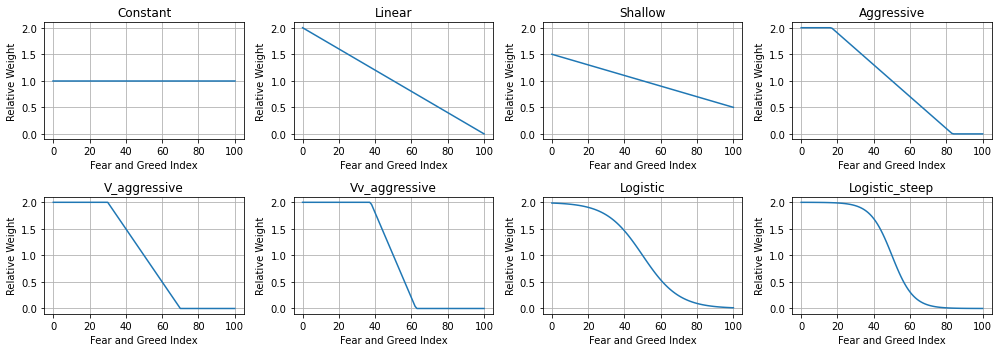

In [36]:
new_weight_df = apply_weighting(weight_df, weight_dict, 'Fear and Greed Index')

In [37]:
for weight_name, weight_func in weight_dict.items():
    fg_w_df['fg_%s' % (weight_name)] =  fg_w_df.fear_greed.apply(weight_func)

## Testing and plotting

In [63]:
params = {
          'amount':   10000,
          'freq_d':   7,
          'dollar':   100,
          'since': datetime.now()-timedelta(days=365*3.3)  
         }

In [64]:
"""

Runs dcas and returns a DCA df with the performance of the different strategies

"""
def run_dcas(fg_w_df, params, weight_dict, ticker='btc', plot=False, print_dca=True):

    print('%s Since: %s\n' % (ticker.upper(), params['since'].strftime('%d %b %Y')))
    this_df = fg_w_df[fg_w_df.ticker==ticker]

    my_dca = DCA(params['amount'], this_df, since=params['since'])

    backtest_df = pd.DataFrame()

    # Calculating the bought volume for the each
    for weight_name in weight_dict:
        vols, spent, prices, dates, ret_df = my_dca.get_average(params['dollar'], params['freq_d'], ticker, weighting='fg_%s'%(weight_name))
        ret_df['portfolio_value'] = ret_df.crypto_tot * ret_df.price + ret_df.dollar_left
        ret_df['weighting'] = weight_name
        backtest_df = backtest_df.append(ret_df)

        # Optional plotting
        if plot:
            fig, ax = plt.subplots(1,2,figsize=(15,3))

            ax1 = ax[0]
            ax2 = ax[0].twinx()
            ax3 = ax[1]
            ax4 = ax[1].twinx()
            ax5 = ax[1].twinx()

            ax1.plot(dates,fg_w_df[fg_w_df.ticker==ticker].loc[dates].close, color='orange',label=ticker)
            ax2.plot(dates, fg_w_df[fg_w_df.ticker==ticker].loc[dates].fear_greed, color='r', label='Fear and Greed')

            ax3.plot(dates, list(accumulate(vols)), color='b', label=ticker+' accumulated')
        #     ax5.plot(dates, list(accumulate(vols), color='r', label='Portfolio Value ($)')
            ax4.plot(dates, vols, color='g', label='Daily Vol')

            ax1.set_yscale('log')
            ax1.legend(loc='lower right')
            ax2.legend(loc='upper left')
            ax3.legend(loc='upper right')
            ax4.legend(loc='lower left')

            plt.show()
            
        if print_dca:
            print('%s DCA:    %.6f %s    $%.2f Leftover\n' % (weight_name, sum(vols), ticker.upper(), params['amount']-spent))
        
    return backtest_df

"""

Plots dca methods with different weighting and stategies over time
Gives the amount in $ of the crypto you would own

"""
def plot_dcas(backtest_df, title_str='DCA strategies over time'):
    plt.figure(figsize=(13,7))
    
    for weight_name in backtest_df.weighting.unique():
        sub_df = backtest_df[backtest_df.weighting==weight_name]
        
        finish_df = sub_df[sub_df.dollar_left <= 0]
        if not finish_df.empty:
            finish_row = finish_df.iloc[0]
            plt.scatter([finish_row.name],[finish_row.portfolio_value], marker='^', s=[100], zorder=10)
        else:
            finish_row = sub_df.iloc[-1]
        label = label='$%.0f ~ %.0f%% invested - %s' % (sub_df.iloc[-1].portfolio_value, 100*(
            1-sub_df.iloc[-1].dollar_left/(sub_df.iloc[-1].dollar_left+sub_df.iloc[-1].dollar_spend_tot)), weight_name)
        plt.plot(sub_df.index,sub_df.portfolio_value,label=label,linewidth=1)
        
    plt.title(title_str)
    plt.yscale('log')
    plt.legend()
    plt.show()

BTC Since: 10 May 2018



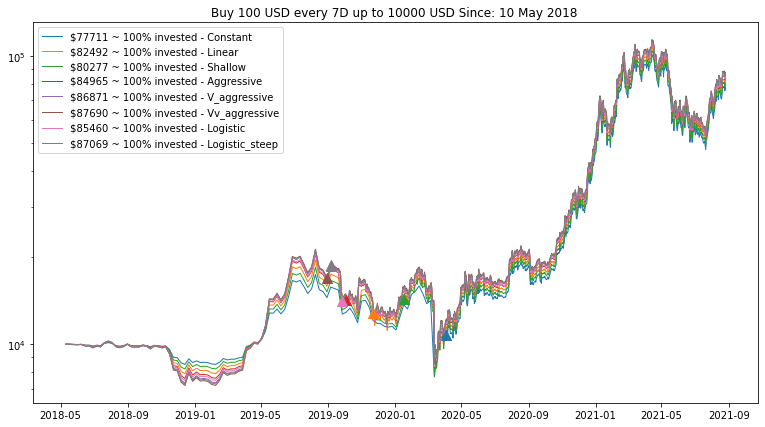

BTC Since: 31 Jan 2019



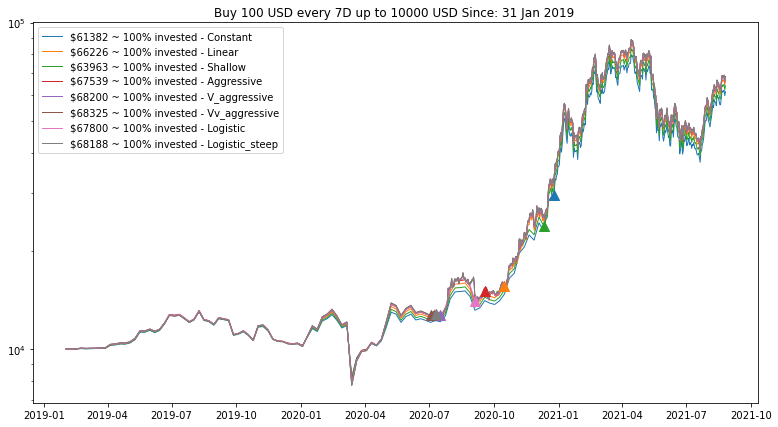

BTC Since: 24 Oct 2019



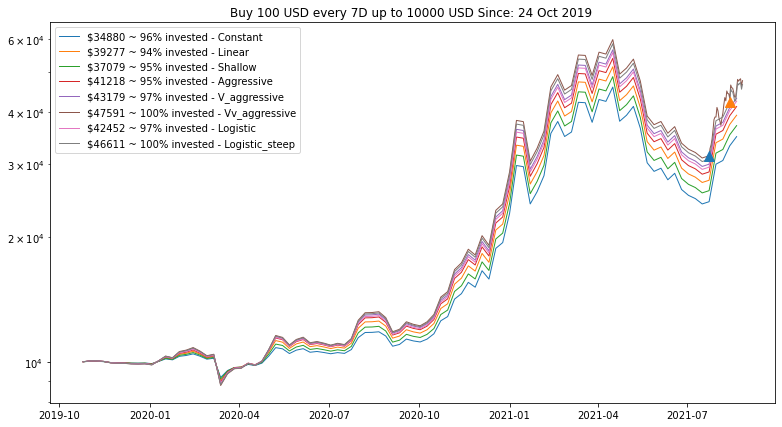

BTC Since: 16 Jul 2020



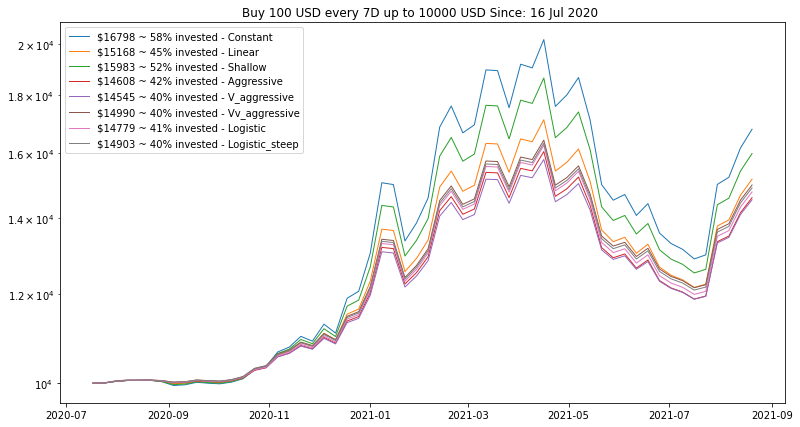

BTC Since: 08 Apr 2021



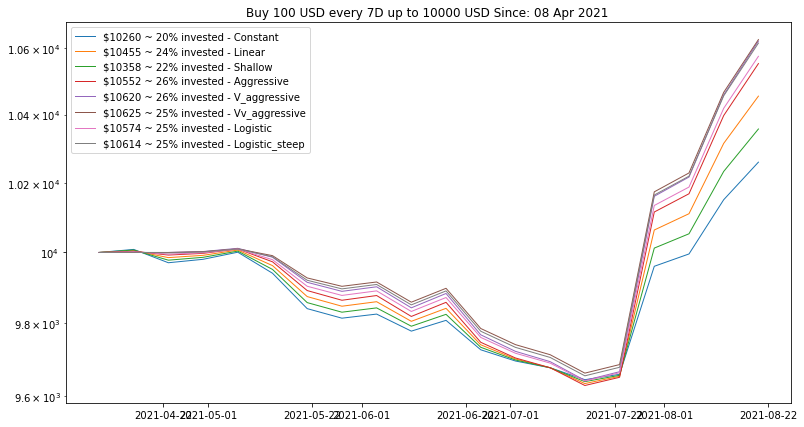

In [62]:
since_dates = pd.date_range(start=datetime.now()-timedelta(days=365*3.3), end=datetime.now()-timedelta(weeks=20), periods=5)
for since in since_dates:
    params['since'] = since
    backtest_df = run_dcas(fg_w_df, params, weight_dict, plot=False, print_dca=False)
    title_str = 'Buy %d USD every %dD up to %d USD Since: %s ' % (params['dollar'],params['freq_d'], params['amount'],
                                                                            params['since'].strftime('%d %b %Y'))
    plot_dcas(backtest_df, title_str)

BTC 

Maximum $90000.00 invested on: Oct 25 20
Regular DCA:    13.093961 BTC   $0.00 Leftover

Maximum $90000.00 invested on: Oct 25 20


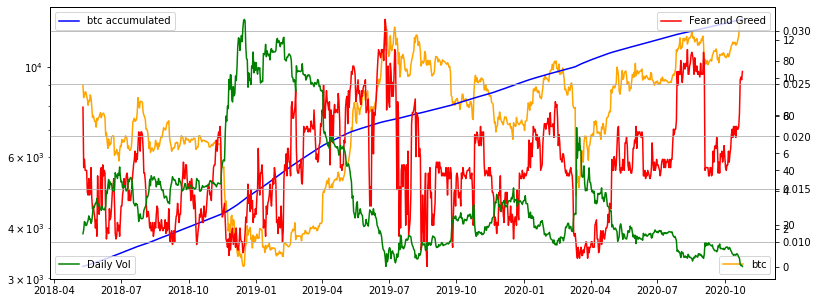

Constant DCA:    13.093961 BTC    $0.00 Leftover

Maximum $90000.00 invested on: Apr 30 20


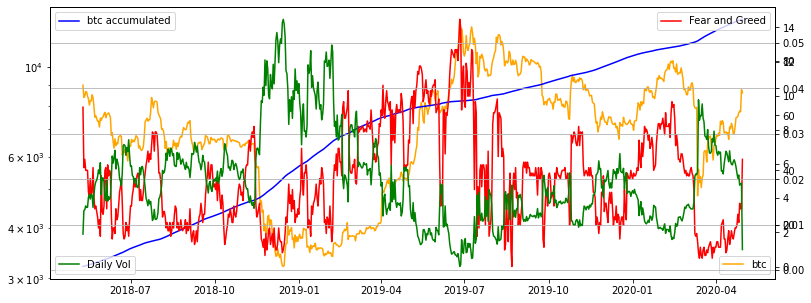

Linear DCA:    14.474277 BTC    $0.00 Leftover

Maximum $90000.00 invested on: Mar 19 20


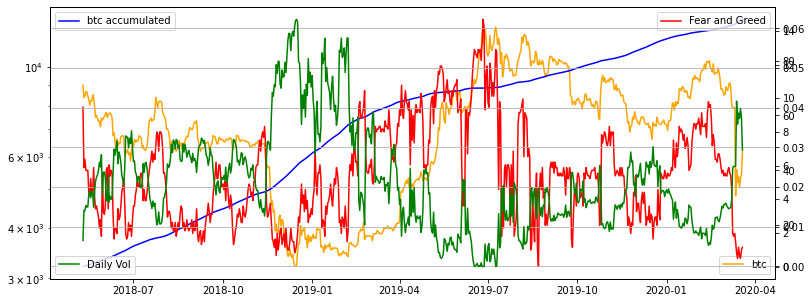

Aggressive DCA:    14.690572 BTC    $0.00 Leftover

Maximum $90000.00 invested on: Feb 01 20


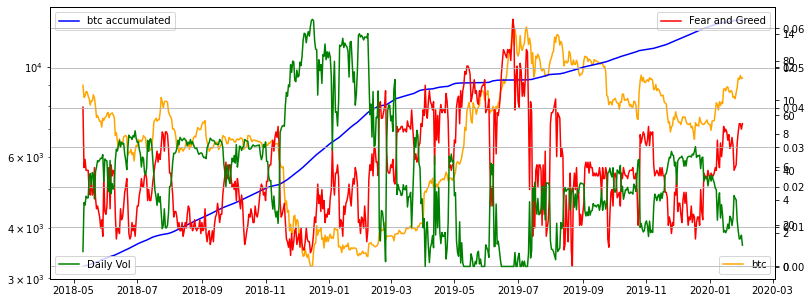

V_aggressive DCA:    14.884772 BTC    $0.00 Leftover

Maximum $90000.00 invested on: Jan 04 20


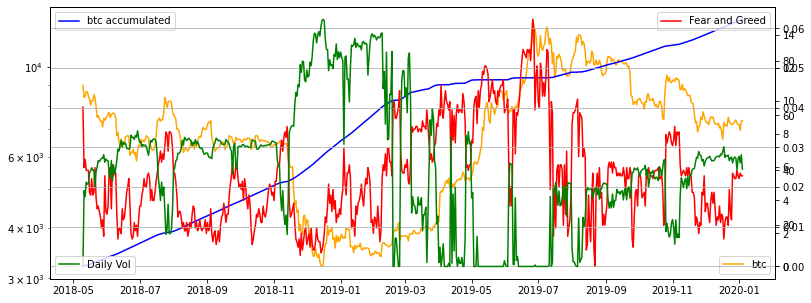

Vv_aggressive DCA:    14.946473 BTC    $0.00 Leftover

Maximum $90000.00 invested on: Mar 05 20


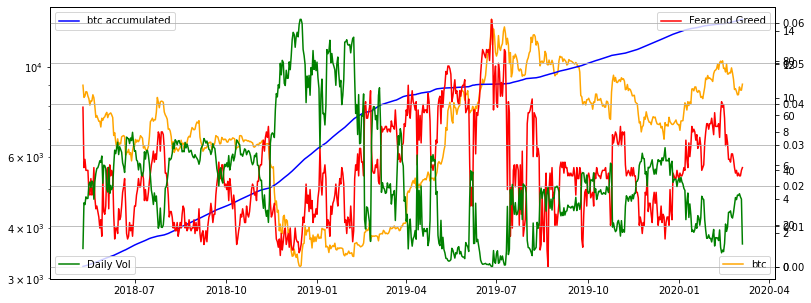

Logistic DCA:    14.671592 BTC    $0.00 Leftover

Maximum $90000.00 invested on: Jan 20 20


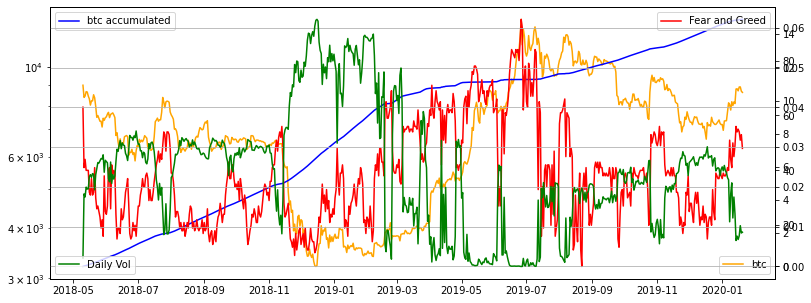

Logistic_steep DCA:    14.894344 BTC    $0.00 Leftover






In [55]:
ticker = 'btc'

print(ticker.upper(),'\n')
this_df = fg_w_df[fg_w_df.ticker==ticker]

my_dca = DCA(params['amount'], this_df)

vols, spent, prices, dates = my_dca.get_average(params['dollar'], params['freq_d'], ticker)
print('Regular DCA:    %.6f %s   $%.2f Leftover\n' % (sum(vols), ticker.upper(), params['amount']-spent))

# Calculating the bought volume for the each
for weight_name in weight_dict:
    vols, spent, prices, dates = my_dca.get_average(params['dollar'], params['freq_d'], ticker, weighting='fg_%s'%(weight_name))
    
    fig, ax1 = plt.subplots(figsize=(13,5))

    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    ax4 = ax1.twinx()

    ax1.plot(dates,fg_w_df[fg_w_df.ticker==ticker].loc[dates].close, color='orange',label=ticker)
    ax2.plot(dates, list(accumulate(vols)), color='b', label=ticker+' accumulated')
    ax3.plot(dates, fg_w_df[fg_w_df.ticker==ticker].loc[dates].fear_greed, color='r', label='Fear and Greed')
    ax4.plot(dates, vols, color='g', label='Daily Vol')
    
    ax1.set_yscale('log')
    ax1.legend(loc='lower right')
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper right')
    ax4.legend(loc='lower left')
    plt.grid()
    plt.show()
    
    print('%s DCA:    %.6f %s    $%.2f Leftover\n' % (weight_name, sum(vols), ticker.upper(), params['amount']-spent))

print('\n\n')

## Exponentially decreasing with price

In [48]:
exp_df = fg_df.copy()

In [49]:
max_price = 30000
min_price = 1000
aggression = 1
expstr = 'exp_'

In [50]:
exp_dict = {}
line = np.linspace(min_price, max_price, 101)

exp_weight_df = pd.DataFrame(line, columns=['line'])
exp_weight_df.sort_values('line',ascending=False).reset_index(inplace=True)
exp_weight_df.index = exp_weight_df.line
exp_weight_df

,line
line,
1000.0,1000.0
1290.0,1290.0
1580.0,1580.0
1870.0,1870.0
2160.0,2160.0
...,...
28840.0,28840.0
29130.0,29130.0
29420.0,29420.0


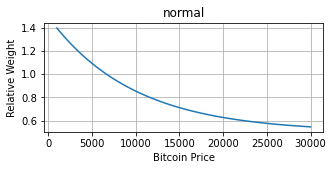

In [51]:
weight_name = 'normal'
# exp_dict[weight_name] = agg1 = lambda x : np.exp(-x/(max_price-min_price)*3+1.2)
exp_dict[weight_name] = agg1 = lambda x : np.exp(-3*x/(max_price-min_price))+0.5
apply_weighting(exp_weight_df, weight_name, agg1, 'Bitcoin Price', replace=True)

In [52]:
for weight_name, weight_func in exp_dict.items():
    exp_df['%s%s' % (expstr, weight_name)] =  exp_df.close.apply(weight_func)

In [53]:
params = {'amount':   90000,
          'freq_d':   1,
          'dollar':   100
         }

df = exp_df


for ticker in all_tickers:
    if ticker == 'btc':

        print(ticker.upper(),'\n')
        this_df = df[df.ticker==ticker]

        my_dca = DCA(params['amount'], this_df)


        vols, spent, prices = my_dca.get_average(params['dollar'], params['freq_d'], ticker, )
        print('Regular DCA:    %.6f %s   $%.2f Leftover\n' % (sum(vols), ticker.upper(), params['amount'] - spent))

        # Calculating the bought volume for the each
        for weight_name in exp_dict:
            vols, spent, prices = my_dca.get_average(params['dollar'], params['freq_d'], ticker, weighting='%s%s'%(expstr, weight_name))
            print('%s DCA:    %.6f %s    $%.2f Leftover\n' % (weight_name, sum(vols), ticker.upper(), params['amount'] - spent))

        print('\n\n')

BTC 

Maximum $90000.00 invested on: Oct 25 20


ValueError: too many values to unpack (expected 3)